In [2]:
import torch
import pandas as pd
import numpy as np
from models.resnetv2 import ResNet50, ResNet101
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader
import matplotlib.pyplot as plt

# UTILS

In [3]:
from PIL import Image

WIDTH = 256
HEIGHT = 256
ROOT = "melanoma/data/train/train/"

def stacked_img(img_path, extra_img):
    img = Image.open(ROOT + img_path + ".jpg")

    new_im = Image.new('RGB', (2 * WIDTH, HEIGHT))
    new_im.paste(img, (0, 0))
    new_im.paste(extra_img, (WIDTH, 0))
    return new_im

def show_sample(img_path):
    img = Image.open(ROOT + img_path + ".jpg")
    return img

In [4]:
def iterate_class(dataset, find_melanoma=1):
    for idx in range(len(dataset)):
        if dataset[idx][1] == find_melanoma:
            yield dataset[idx][0].view(1, 3, 256, 256), dataset.lookup_path(idx)

# END UTILS

In [5]:
# melanoma model
# !wget -O model_melanoma https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0

In [6]:
path_to_model = 'model_melanoma'

In [7]:
model = ResNet50(out_features = 2, freeze = True, in_channels = 3)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
msg1 = model.load_state_dict(checkpoint1['model'], strict=False)
msg1

<All keys matched successfully>

In [17]:
make_dataset = lambda: Melanoma_loader(root = "melanoma/data/train/train", ann_path = "melanoma/data/test_set.csv",
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [18]:
melanoma_generator = iterate_class(make_dataset(), find_melanoma=1)
nonmelanoma_generator = iterate_class(make_dataset(), find_melanoma=0)

model = model.eval()

## LRP

In [20]:
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient
from zennit.image import imgify

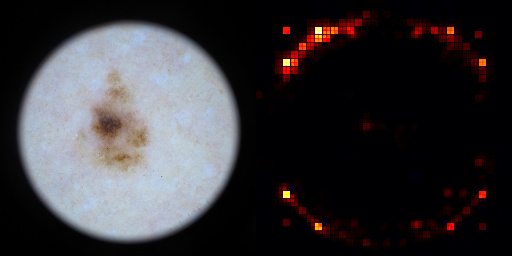

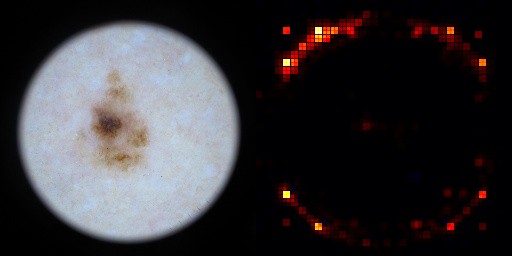

In [37]:
# Based on https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# test_tensor, path = next(generator)
model = model.eval()

# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# target = torch.eye(2)[[1]]
target = torch.eye(2)[[1]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(test_tensor, target)
    
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')
new_img = stacked_img(path, img)
# show the image
display(new_img)

target = torch.eye(2)[[0]]
# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(test_tensor, target)
    
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')
new_img = stacked_img(path, img)
# show the image
display(new_img)

LRP explained: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

# CRP

In [38]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.eval()


# sample, path = next(generator)

In [39]:

from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept

cc = ChannelConcept()
attribution = CondAttribution(model)

In [40]:
itera = 0

In [41]:
sample.shape

torch.Size([1, 3, 256, 256])

In [44]:
# Image.image(sample.squeeze(0).permute(1, 2, 0).detach().numpy())
# show_sample(path)
path

'ISIC_0064448'

In [47]:
from crp.helper import get_layer_names

# use the ResNet-specific canonizer
canonizer = HackCanonizer(True)

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# compute heatmap wrt. output 46 (green lizard class)
concept_ids = list(range(4))
# conditions = [{'backbone.conv1': [ids], 'y': [1]} for ids in concept_ids]
conditions = [{'layer1.0.conv1': [ids], 'y': [1]} for ids in concept_ids]
# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite)

# or use a dictionary for mask_map

heatmaps, _, _, _ = attribution(sample, conditions, composite)
from crp.image import imgify

print(torch.equal(attr[0], heatmaps), itera)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(img)
                                                       
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)

TypeError: argument of type 'bool' is not iterable

True 1


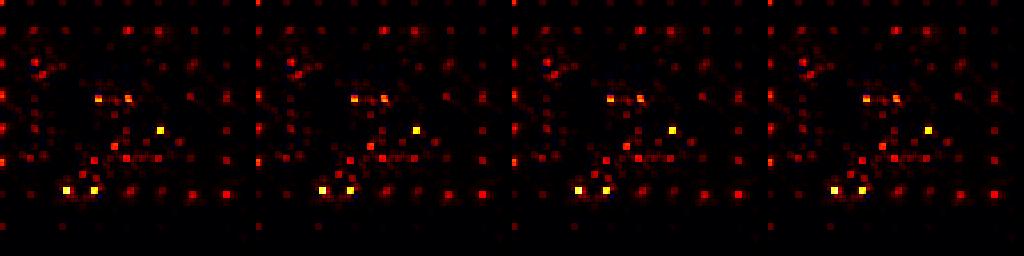

In [36]:
from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)
concept_ids = list(range(4))
# conditions = [{'backbone.conv1': [ids], 'y': [1]} for ids in concept_ids]
conditions = [{'layer1.0.conv1': [range(10)], 'y': [1]} for ids in concept_ids]
itera += 1
# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite)

# or use a dictionary for mask_map

heatmaps, _, _, _ = attribution(sample, conditions, composite)
from crp.image import imgify

print(torch.equal(attr[0], heatmaps), itera)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(img)
                                                       
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)

In [45]:
from zennit.canonizers import SequentialMergeBatchNorm, AttributeCanonizer, CompositeCanonizer
from zennit.torchvision import ResNetBottleneckCanonizer, ResNetBasicBlockCanonizer
from torchvision.models.resnet import Bottleneck as ResNetBottleneck
from zennit.layer import Sum

class HackBottleneckCanonizer(ResNetBottleneckCanonizer):
    def __init__(self, overwrite_names):
        AttributeCanonizer.__init__(self, self.get_attribute_map(overwrite_names))
        
    
    @classmethod
    def get_attribute_map(cls, overwrite_names):
        
        def _attribute_map(name, module):
            if isinstance(module, ResNetBottleneck):
                if name in overwrite_names:
                    attributes = {
                        'forward': cls.forward_no_grad.__get__(module),
                        'canonizer_sum': Sum(),
                    }
                    return attributes
                else:
                    attributes = {
                        'forward': cls.forward.__get__(module),
                        'canonizer_sum': Sum(),
                    }
                    return attributes
                return None
        return _attribute_map
    
    @staticmethod
    def forward_no_grad(self, x):
        '''
        Modified Bottleneck forward for HackResNet.
        This forward doesn't propagate gradient through skip connections of given layers.
        '''
        identity = x.clone().detach()
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
            
        out = torch.stack([identity, out], dim=-1)
        out = self.canonizer_sum(out)

        out = self.relu(out)

        return out


class HackCanonizer(CompositeCanonizer):
    def __init__(self, grad_omit_skips):
        super().__init__((
            SequentialMergeBatchNorm(),
            HackBottleneckCanonizer(grad_omit_skips),
            ResNetBasicBlockCanonizer(),
        ))



In [37]:
canonizer.canonizers

(<zennit.canonizers.SequentialMergeBatchNorm at 0x7fb48a57f310>,
 <zennit.torchvision.ResNetBasicBlockCanonizer at 0x7fb48a572f10>)

In [38]:
canonizer.canonizers[1]._attribute_map("layer1.0", model.layer1[0])

AttributeError: 'ResNet50' object has no attribute 'layer1'

In [ ]:
len(canonizer.canonizers[1].apply(model))

In [ ]:
canonizer.canonizers[1].apply(model)

In [ ]:
composite.handles